In [1]:
import torch
import torchaudio
import PIL.Image
import matplotlib.pyplot as plt
import einops
from IPython.display import Audio as play
from datasets import load_dataset, Audio
from torchvision.transforms.v2 import PILToTensor, ToPILImage

In [2]:
vox_celeb = load_dataset("danjacobellis/vox_celeb_v1",split='train').cast_column('opus', Audio(decode=False))
imagenet1k = load_dataset('danjacobellis/imagenet_288_webp',split='train')

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/66 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/66 [00:00<?, ?it/s]

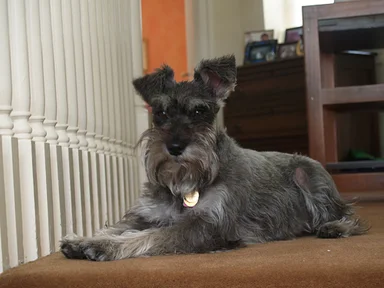

In [3]:
x_audio, fs = torchaudio.load(vox_celeb[-3]['opus']['bytes'],normalize=False);
assert fs==48000
assert x_audio.min() >= -1.0; assert x_audio.max() <= 1.0
# display(play(x_audio, rate=fs))
x_image = PILToTensor()(imagenet1k[0]['webp'])/255 - 0.5
assert x_image.min() >= -1.0; assert x_image.max() <= 1.0
assert x_image.shape[0] == 3; assert x_image.shape[1] >= 288; assert x_image.shape[2] >= 288
display(ToPILImage()(x_image+0.5))

In [4]:
def strfft(x: torch.Tensor):
    assert x.dim() == 3, "Input must be (batch, channels, length) for strfft."
    B, C, T = x.shape
    frame_size = int(torch.sqrt(torch.tensor(T, dtype=torch.float)).floor().item())
    if frame_size < 1:
        raise ValueError(f"Computed frame_size < 1 (T={T})")
    remainder = T % frame_size
    if remainder != 0:
        total_pad = frame_size - remainder
        left_pad = total_pad // 2
        right_pad = total_pad - left_pad
    else:
        left_pad = 0
        right_pad = 0
    padder = torch.nn.ReflectionPad1d((left_pad, right_pad))
    x_padded = padder(x)
    T_padded = x_padded.shape[-1]
    n_frames = T_padded // frame_size
    frames = x_padded.view(B, C, n_frames, frame_size)
    X = torch.fft.rfft(frames, dim=-1)
    return X, (left_pad, right_pad, frame_size)


def istrfft(X: torch.Tensor, pad_info: tuple):
    left_pad, right_pad, frame_size = pad_info
    B, C, n_frames, freq_bins = X.shape
    frames = torch.fft.irfft(X, n=frame_size, dim=-1)
    x_padded = frames.reshape(B, C, -1)
    T_padded = x_padded.shape[-1]
    if left_pad + right_pad > 0:
        x_reconstructed = x_padded[..., left_pad : T_padded - right_pad]
    else:
        x_reconstructed = x_padded

    return x_reconstructed

x = x_audio.unsqueeze(0)
X, pad_info = strfft(x)
y = istrfft(X, pad_info)
(x - y).abs().max()

tensor(2.5332e-07)

In [5]:
display(play(y[0],rate=48000))

In [6]:
import math
import torch
import torch.nn as nn

def strfft2(x: torch.Tensor):
    B, C, H, W = x.shape
    frame_size = math.floor(math.sqrt(min(H, W)))
    pad_h = 0 if (H % frame_size == 0) else (frame_size - (H % frame_size))
    pad_w = 0 if (W % frame_size == 0) else (frame_size - (W % frame_size))
    pad_top = pad_h // 2
    pad_bottom = pad_h - pad_top
    pad_left = pad_w // 2
    pad_right = pad_w - pad_left
    padder = nn.ReflectionPad2d((pad_left, pad_right, pad_top, pad_bottom))
    x_padded = padder(x)
    _, _, Hp, Wp = x_padded.shape
    x_blocks = x_padded.reshape(
        B, C,
        Hp // frame_size, frame_size,
        Wp // frame_size, frame_size
    )
    x_blocks = x_blocks.permute(0, 1, 2, 4, 3, 5)
    X_stft = torch.fft.rfft2(x_blocks, dim=(-2, -1))
    pad_sizes = (pad_left, pad_right, pad_top, pad_bottom)
    orig_shape = (H, W)
    return X_stft, frame_size, pad_sizes, orig_shape

def istrfft2(X_stft: torch.Tensor,
             frame_size: int,
             pad_sizes: tuple,
             orig_shape: tuple):
    pad_left, pad_right, pad_top, pad_bottom = pad_sizes
    orig_H, orig_W = orig_shape
    B, C, nH, nW, _, _ = X_stft.shape
    x_blocks = torch.fft.irfft2(X_stft, s=(frame_size, frame_size), dim=(-2, -1))
    x_blocks = x_blocks.permute(0, 1, 2, 4, 3, 5)
    x_padded = x_blocks.reshape(
        B, C,
        nH * frame_size,
        nW * frame_size
    )
    if pad_bottom > 0:
        x_padded = x_padded[:, :, :-pad_bottom, :]
    if pad_right > 0:
        x_padded = x_padded[:, :, :, :-pad_right]
    if pad_top > 0:
        x_padded = x_padded[:, :, pad_top:, :]
    if pad_left > 0:
        x_padded = x_padded[:, :, :, pad_left:]
    x_recovered = x_padded[:, :, :orig_H, :orig_W]
    return x_recovered

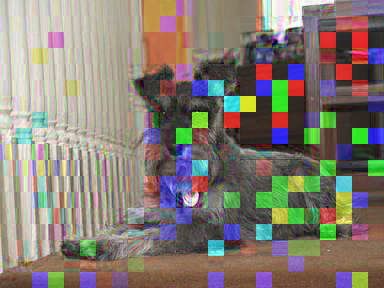

In [7]:
def stft_dropout_2d(x,batch=False):
    if not batch:
        x = x.unsqueeze(0)
    X, frame_size, pad_sizes, orig_shape = strfft2(x)
    _, c, _, _, u, v = X.shape
    Xr, Xi = X.real, X.imag
    Xm, Xp = X.abs(), X.angle()
    
    Xm = einops.rearrange(Xm, 'b c h w u v -> b (c u v) h w')
    Xm = torch.nn.functional.dropout(Xm, p=torch.rand(1).item(), training=True)
    Xm = einops.rearrange(Xm, 'b (c u v) h w -> b c h w u v', c=c, u=u, v=v)
    
    Xp = einops.rearrange(Xp, 'b c h w u v -> b (c u v) h w')
    Xp = torch.nn.functional.dropout(Xp, p=torch.rand(1).item(), training=True)
    Xp = einops.rearrange(Xp, 'b (c u v) h w -> b c h w u v', c=c, u=u, v=v)
    
    X = Xm * torch.exp(1j*Xp)
    y = istrfft2(X, frame_size, pad_sizes, orig_shape)
    if not batch:
        y = y[0]
    return y

display(ToPILImage()(stft_dropout_2d(x_image).clamp(-0.5,0.5)+0.5))